In [27]:
import voxelwise_tutorials
from himalaya.ridge import RidgeCV
import numpy as np
from pathlib import Path
from AOTaccess.stimulus_info_access import StimuliInfoAccess
from AOTaccess.glmsingle_access import GLMSingleAccess
from AOTanalysis.bandedRR.construct_features import (
    construct_features_motion_energy,
    construct_features_sbert_embeddings,
)
from AOTanalysis.bandedRR.construct_target import (
    construct_target_data_split_flatten_masked,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from voxelwise_tutorials.delayer import Delayer
from himalaya.backend import set_backend

backend = set_backend("torch_cuda", on_error="warn")

from himalaya.kernel_ridge import MultipleKernelRidgeCV
from himalaya.kernel_ridge import Kernelizer
from sklearn import set_config
from himalaya.kernel_ridge import ColumnKernelizer
from voxelwise_tutorials.utils import explainable_variance
from AOTanalysis.bandedRR.utils import (
    reshape_from_flatten_masked_to_wholebrain,
)
from AOTanalysis.voxelsemantic.corpus_construct import construct_AOT_corpus
import joblib
from pprint import pprint

backend = set_backend("numpy", on_error="warn")

/tank/zhangs/anaconda3/lib/python3.9/site-packages/himalaya/backend/_utils.py:55: UserWarning: Setting backend to torch_cuda failed: PyTorch with CUDA is not available..Falling back to numpy backend.
  warnings.warn(f"Setting backend to {backend} failed: {str(error)}."


In [28]:
def data_construct(sub, n_splits, split_index, direction, feature_names):
    video_betas, video_index = construct_target_data_split_flatten_masked(
        sub,
        n_splits,
        split_index,
        centered=True,
        randomize=True,
        direction=direction,
    )
    y = video_betas
    print(f"Shape of y: {y.shape}")

    if np.isnan(y).any() or np.isinf(y).any():
        y = np.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)

    X_list = []
    for feature_name in feature_names:
        if feature_name == "motion_energy":
            X = construct_features_motion_energy(video_index)
        elif feature_name == "semantic_embeddings":
            X = construct_features_sbert_embeddings(video_index)
        else:
            raise ValueError("feature name do not match")
        print(f"Shape of {feature_name}: {X.shape}")
        X_list.append(X)
    n_features_list = [X.shape[1] for X in X_list]
    X = np.concatenate(X_list, axis=1)
    print(f"Shape of X: {X.shape}")
    return X, y, n_features_list

In [29]:
X, y, n_features_list = data_construct(
    sub=1,
    n_splits=10,
    split_index=2,
    direction="fw",
    feature_names=["motion_energy", "semantic_embeddings"],
)

Loaded beta from /tank/shared/2024/visual/AOT/derivatives/glmsingle/video_betas/sub-001/0001_fw_betas.nii
Shape of beta: (2, 86, 104, 88)
Loaded betas for video 1
Shape of betas: (2, 86, 104, 88)
Loaded beta from /tank/shared/2024/visual/AOT/derivatives/glmsingle/video_betas/sub-001/0002_fw_betas.nii
Shape of beta: (2, 86, 104, 88)
Loaded betas for video 2
Shape of betas: (2, 86, 104, 88)
Loaded beta from /tank/shared/2024/visual/AOT/derivatives/glmsingle/video_betas/sub-001/0003_fw_betas.nii
Shape of beta: (2, 86, 104, 88)
Loaded betas for video 3
Shape of betas: (2, 86, 104, 88)
Loaded beta from /tank/shared/2024/visual/AOT/derivatives/glmsingle/video_betas/sub-001/0004_fw_betas.nii
Shape of beta: (2, 86, 104, 88)
Loaded betas for video 4
Shape of betas: (2, 86, 104, 88)
Loaded beta from /tank/shared/2024/visual/AOT/derivatives/glmsingle/video_betas/sub-001/0005_fw_betas.nii
Shape of beta: (2, 86, 104, 88)
Loaded betas for video 5
Shape of betas: (2, 86, 104, 88)
Loaded beta from /ta

Loaded beta from /tank/shared/2024/visual/AOT/derivatives/glmsingle/video_betas/sub-001/0462_fw_betas.nii
Shape of beta: (2, 86, 104, 88)
Loaded betas for video 462
Shape of betas: (2, 86, 104, 88)
Loaded beta from /tank/shared/2024/visual/AOT/derivatives/glmsingle/video_betas/sub-001/0463_fw_betas.nii
Shape of beta: (2, 86, 104, 88)
Loaded betas for video 463
Shape of betas: (2, 86, 104, 88)
Loaded beta from /tank/shared/2024/visual/AOT/derivatives/glmsingle/video_betas/sub-001/0464_fw_betas.nii
Shape of beta: (2, 86, 104, 88)
Loaded betas for video 464
Shape of betas: (2, 86, 104, 88)
Loaded beta from /tank/shared/2024/visual/AOT/derivatives/glmsingle/video_betas/sub-001/0465_fw_betas.nii
Shape of beta: (2, 86, 104, 88)
Loaded betas for video 465
Shape of betas: (2, 86, 104, 88)
Loaded beta from /tank/shared/2024/visual/AOT/derivatives/glmsingle/video_betas/sub-001/0466_fw_betas.nii
Shape of beta: (2, 86, 104, 88)
Loaded betas for video 466
Shape of betas: (2, 86, 104, 88)
File /tank

In [30]:
def construct_enduce_input(n_features_list, negative=False):
    print(n_features_list)
    total_dim = sum(n_features_list)
    print(total_dim)
    onehot_positive = np.zeros((total_dim, total_dim))
    for i in range(total_dim):
        onehot_positive[i, i] = 1
    if negative:
        onehot_negative = np.zeros((total_dim, total_dim))
        for i in range(total_dim):
            onehot_negative[i, i] = -1
        onehot = np.concatenate([onehot_positive, onehot_negative], axis=0)
    else:
        onehot = onehot_positive
    print(onehot.shape)
    return onehot

In [31]:
enduce_X = construct_enduce_input(n_features_list)

[2162, 768]
2930
(2930, 2930)


In [32]:
model_path = "/tank/shared/2024/visual/AOT/temp/bandedRR_split_motion_sbert768_Xprecentered/model_sub1_split0_fw.joblib"
model = joblib.load(model_path)
set_config(display="diagram")
model


print(model.steps[1][1])
MultipleKernelRidgeCV_instance = model.steps[1][1]
#?MultipleKernelRidgeCV_instance
# fitweights = MultipleKernelRidgeCV_instance.dual_coef_
# print(fitweights.shape)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [19]:
enduced_predict = model.predict(enduce_X)
print(enduced_predict.shape)
# switch the axis
enduced_predict = enduced_predict.T
print(enduced_predict.shape)

# get the motion part
motion_predict = enduced_predict[:, :2162]
print(motion_predict.shape)

#get the max value index of each voxel
max_index = np.argmax(motion_predict, axis=1)
print(max_index.shape)

In [ ]:
# f
import moten    
SIZE = [160, 240]
FPS = 24
pyramid = moten.get_default_pyramid(vhsize=SIZE, fps=FPS,
size_list = pyramid.get_filter_pixel_sizes()
pprint(size_list)
print(len(size_list))


[38400,
 38400,
 38400,
 38400,
 38400,
 38400,
 38400,
 38400,
 38400,
 38400,
 38400,
 38400,
 38400,
 38400,
 38400,
 38400,
 38400,
 38400,
 38400,
 38400,
 38400,
 38400,
 38400,
 24420,
 23852,
 24420,
 23852,
 24420,
 23852,
 24390,
 24390,
 24390,
 24444,
 24444,
 24444,
 24390,
 24390,
 24390,
 24420,
 24420,
 24390,
 24390,
 24444,
 24444,
 24390,
 24390,
 5848,
 5723,
 5848,
 5723,
 5848,
 5723,
 6072,
 5910,
 6072,
 5910,
 6072,
 5910,
 5848,
 5723,
 5848,
 5723,
 5848,
 5723,
 6162,
 6004,
 6162,
 6004,
 6162,
 6004,
 6388,
 6176,
 6388,
 6176,
 6388,
 6176,
 6162,
 6004,
 6162,
 6004,
 6162,
 6004,
 6172,
 5996,
 6172,
 5996,
 6172,
 5996,
 6388,
 6180,
 6388,
 6180,
 6388,
 6180,
 6172,
 5996,
 6172,
 5996,
 6172,
 5996,
 6162,
 6004,
 6162,
 6004,
 6162,
 6004,
 6388,
 6176,
 6388,
 6176,
 6388,
 6176,
 6162,
 6004,
 6162,
 6004,
 6162,
 6004,
 5848,
 5723,
 5848,
 5723,
 5848,
 5723,
 6072,
 5910,
 6072,
 5910,
 6072,
 5910,
 5848,
 5723,
 5848,
 5723,
 5848,
 5723,
 5

392 1311


(array([1771.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,   12.,  144.,  189.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    3.,    0.,   20.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          23.]),
 array([ 1311.  ,  1681.89,  2052.78,  2423.67,  2794.56,  3165.45,
         3536.34,  3907.23,  4278.12,  4649.01,  5019.9 ,  5390.79,
         5761.68,  6132.57,  6503.46,  6874.35,  7245.24,  7616.13

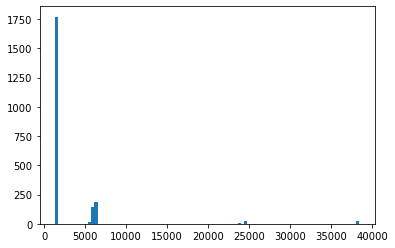

In [21]:

import matplotlib.pyplot as plt
print(np.argmin(size_list),np.min(size_list))

plt.hist(size_list, bins=100)


dict_keys(['centerh', 'centerv', 'direction', 'spatial_freq', 'spatial_env', 'temporal_freq', 'temporal_env', 'filter_temporal_width', 'aspect_ratio', 'stimulus_fps', 'spatial_phase_offset'])
array([ 2.,  0.,  2., ..., 16., 16., 16.])


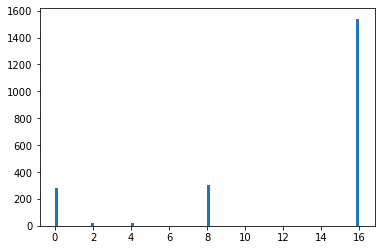

In [22]:
#pyramid.show_filter(2161)


print(pyramid.parameters.keys())

spatial_freq = pyramid.parameters["spatial_freq"]
plt.hist(spatial_freq, bins=100)

pprint(spatial_freq)

array([0., 0., 2., ..., 4., 2., 4.])


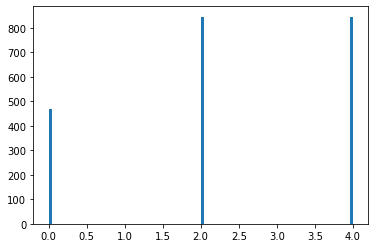

In [24]:
temporal_freq = pyramid.parameters["temporal_freq"]
plt.hist(temporal_freq, bins=100)

pprint(temporal_freq)


In [26]:
def velocity(spatial_freq, temporal_freq):
    v = temporal_freq / spatial_freq
    return v

def velovity_from_index(index):
    spatial_freq = pyramid.parameters["spatial_freq"][index]
    temporal_freq = pyramid.parameters["temporal_freq"][index]
    return velocity(spatial_freq, temporal_freq)

for i in range(2162):
    print(velovity_from_index(i))

0.0
nan
1.0
inf
2.0
inf
0.0
1.0
2.0
0.0
1.0
2.0
0.0
1.0
2.0
1.0
2.0
1.0
2.0
1.0
2.0
1.0
2.0
0.0
nan
0.5
inf
1.0
inf
0.0
0.5
1.0
0.0
0.5
1.0
0.0
0.5
1.0
0.5
1.0
0.5
1.0
0.5
1.0
0.5
1.0
0.0
nan
0.25
inf
0.5
inf
0.0
nan
0.25
inf
0.5
inf
0.0
nan
0.25
inf
0.5
inf
0.0
nan
0.25
inf
0.5
inf
0.0
nan
0.25
inf
0.5
inf
0.0
nan
0.25
inf
0.5
inf
0.0
nan
0.25
inf
0.5
inf
0.0
nan
0.25
inf
0.5
inf
0.0
nan
0.25
inf
0.5
inf
0.0
nan
0.25
inf
0.5
inf
0.0
nan
0.25
inf
0.5
inf
0.0
nan
0.25
inf
0.5
inf
0.0
nan
0.25
inf
0.5
inf
0.0
nan
0.25
inf
0.5
inf
0.0
nan
0.25
inf
0.5
inf
0.0
0.25
0.5
0.0
0.25
0.5
0.0
0.25
0.5
0.0
0.25
0.5
0.0
0.25
0.5
0.0
0.25
0.5
0.0
0.25
0.5
0.0
0.25
0.5
0.0
0.25
0.5
0.0
0.25
0.5
0.0
0.25
0.5
0.0
0.25
0.5
0.0
0.25
0.5
0.0
0.25
0.5
0.0
0.25
0.5
0.0
0.25
0.5
0.0
0.25
0.5
0.0
0.25
0.5
0.0
0.25
0.5
0.0
0.25
0.5
0.0
0.25
0.5
0.0
0.25
0.5
0.0
0.25
0.5
0.0
0.25
0.5
0.0
0.25
0.5
0.0
0.25
0.5
0.0
0.25
0.5
0.0
0.25
0.5
0.0
0.25
0.5
0.0
0.25
0.5
0.0
0.25
0.5
0.0
0.25
0.5
0.0
0.25
0.5
0.0
0.25
0.5

/tmp/ipykernel_382898/1085807281.py:2: RuntimeWarning: invalid value encountered in double_scalars
  v = temporal_freq / spatial_freq
/tmp/ipykernel_382898/1085807281.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  v = temporal_freq / spatial_freq


In [23]:
# voxel_index = 70000
# filter_index = max_index[voxel_index]
# filter_size = size_list[filter_index]
# print(filter_size)

NameError: name 'max_index' is not defined